In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### NB: ---Nous avons constaté qu'avec la recherche par grille tout comme aléatoire, le score pour l'ensemble des données d'entrainement, est presque parfait avec les métriques 'auc' et 'log loss', pour le modèle KNeighborsClassifier. Raison pour laquelle nous avons décidé de  comparer nos différents modèles sur le best score retournés par la recherche aléatoire /grille, car celui n'est pas affecté par ce problème. Ce pourrait être un bug lié à scikit learn et notre environnement de travail, car d'autres étudiants n'ont pas eu ce problème (Nous travaillons avec l'image docker du cours et avec docker desktop). Nous examinerons d'avantage ce problème plus tard ---

# 1- Bibilothèques

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
#from sklearn.utils.fixes import loguniform
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint
from scipy.stats import loguniform
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

In [3]:
# fonction pour afficher plusieurs courbe ROC sur une même figure
def plot_roc_curve(y_train, results):
    plt.figure().clear()
    for key in results:
        fpr, tpr, thresholds = roc_curve(y_train, results[key], drop_intermediate=False)
        auc = roc_auc_score(y_train, results[key])
        plt.plot(fpr, tpr, label = key +', auc = '+str(auc))
    plt.legend(loc=4)        

In [4]:
# fonctions pour afficher plusieurs diagrammes à baton afin de comparer visuellement les scores log loss
def addlabels(x,y):
    for key in results:
        plt.text(key, results[key], round(results[key],3), ha = 'center')

def plot_log_loss_bar(results):
    x = np.arange(len(results))
    plt.bar(results.keys(), results.values(), width=0.1)
    plt.xticks(rotation=90)
    plt.ylabel('Log los')
    plt.title('Score log loss pour chaque modèle')
    plt.xlabel('Modèles')
    addlabels(results.keys(),results.values())
    plt.show()

# 2- Lecture et exploration des données

In [5]:
donnees = pd.read_csv('../../data/chansons.csv')

In [6]:
# Tailles du jeux de données
donnees.shape

(7574, 39)

In [7]:
# Affichages des 10 premières lignes de données pour en avoir une idée
donnees.head(10)

,annee,titre,artiste,chansonID,artisteID,signature_temp,signature_temp_confiance,intensite,tempo,tempo_confiance,...,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
0,2010,This Is the House That Doubt Built,A Day to Remember,SOBGGAB12C5664F054,AROBSHL1187B9AFB01,3,0.853,-4.262,91.525,0.953,...,82.475,-52.025,39.116,-35.368,71.642,-126.440,18.658,-44.770,25.989,0
1,2010,Sticks & Bricks,A Day to Remember,SOPAQHU1315CD47F31,AROBSHL1187B9AFB01,4,1.000,-4.051,140.048,0.921,...,106.918,-61.320,35.378,-81.928,74.574,-103.808,121.935,-38.892,22.513,0
2,2010,All I Want,A Day to Remember,SOOIZOU1376E7C6386,AROBSHL1187B9AFB01,4,1.000,-3.571,160.512,0.489,...,80.621,-59.773,45.979,-46.293,59.904,-108.313,33.300,-43.733,25.744,0
3,2010,It's Complicated,A Day to Remember,SODRYWD1315CD49DBE,AROBSHL1187B9AFB01,4,1.000,-3.815,97.525,0.794,...,96.675,-78.660,41.088,-49.194,95.440,-102.676,46.422,-59.439,37.082,0
4,2010,2nd Sucks,A Day to Remember,SOICMQB1315CD46EE3,AROBSHL1187B9AFB01,4,0.788,-4.707,140.053,0.286,...,110.332,-56.450,37.555,-48.588,67.570,-52.796,22.888,-50.414,32.758,0
5,2010,Better Off This Way,A Day to Remember,SOCEYON1315CD4A23E,AROBSHL1187B9AFB01,4,1.000,-3.807,160.366,0.347,...,91.117,-54.378,53.808,-33.183,54.657,-64.478,34.522,-40.922,36.453,0
6,2010,All Signs Point to Lauderdale,A Day to Remember,SODZEHH1377566C93F,AROBSHL1187B9AFB01,4,0.968,-4.114,149.967,0.273,...,97.938,-57.289,34.989,-35.724,72.925,-66.070,75.881,-51.232,28.741,0
7,2010,Out of Time,A Day to Remember,SOJQXRI12C5664F058,AROBSHL1187B9AFB01,4,0.861,-3.683,160.328,0.830,...,114.817,-56.108,25.915,-69.726,112.780,-117.207,27.494,-50.713,31.470,0
8,2010,If I Leave,A Day to Remember,SOWCXMH137733DA46E,AROBSHL1187B9AFB01,4,0.622,-4.967,155.112,0.018,...,67.466,-53.234,40.445,-33.081,50.643,-61.121,50.245,-53.695,26.625,0
9,2010,Whataya Want From Me,Adam Lambert,SOFOBLL13A9E22142F,ARIGTAO11FED0C4411,4,0.938,-15.557,95.904,0.929,...,99.150,-69.346,56.233,-94.733,62.789,-102.870,65.328,-48.411,47.376,1


In [8]:
# Statistiques descriptives des colonnees numériques du jeu de données
donnees.describe()

,annee,signature_temp,signature_temp_confiance,intensite,tempo,tempo_confiance,gamme,gamme_confiance,energie,hauteur,...,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
count,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,...,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000
mean,2001.455902,3.893979,0.853307,-8.817262,107.348267,0.622866,5.384605,0.433843,0.675471,0.010817,...,95.653221,-63.703984,50.057489,-59.515016,68.028067,-87.340055,55.520722,-50.868457,47.490774,0.147742
std,5.815223,0.532561,0.243748,4.377079,24.665030,0.304656,3.572579,0.273826,0.243473,0.013671,...,26.859726,15.970244,14.463524,17.190527,20.381321,30.464274,23.549473,11.701530,12.463966,0.354868
min,1990.000000,0.000000,0.000000,-42.451000,0.000000,0.000000,0.000000,0.000000,0.000020,0.000000,...,15.699000,-158.756000,-25.955000,-149.507000,8.415000,-208.819000,-6.359000,-145.599000,7.200000,0.000000
25%,1997.000000,4.000000,0.819250,-10.847000,88.860250,0.372000,2.000000,0.204000,0.500138,0.003000,...,76.498000,-73.050750,40.584500,-70.282500,53.037250,-105.130250,39.196000,-58.058000,38.975250,0.000000
50%,2002.000000,4.000000,0.979000,-7.649000,103.268000,0.701500,6.000000,0.451500,0.718160,0.007000,...,94.632500,-62.661500,49.220000,-58.650000,65.935000,-83.074000,50.895000,-50.892500,46.437500,0.000000
75%,2006.000000,4.000000,1.000000,-5.640000,124.800500,0.892000,9.000000,0.646000,0.887396,0.014000,...,112.708250,-52.982750,58.462000,-47.699750,81.267000,-64.518000,66.593000,-43.292250,55.030250,0.000000
max,2010.000000,7.000000,1.000000,1.305000,244.307000,1.000000,11.000000,1.000000,0.998492,0.541000,...,214.819000,-2.382000,144.985000,1.140000,161.518000,-10.640000,192.417000,-6.497000,110.272000,1.000000


In [9]:
# Statistiques descriptives des colonnes catégoriques
donnees.describe(exclude='number')

,titre,artiste,chansonID,artisteID
count,7574,7574,7574,7574
unique,7141,1032,7549,1047
top,Intro,Various artists,SOKLHIK131343A2E06,ARAGWS81187FB3F768
freq,15,162,2,222


In [10]:
# NB: Nous n'observons aucune valeur manquante au regard des statistiques précédentes

In [11]:
#g = sns.PairGrid(donnees.select_dtypes(include='number'))
#g = g.map(sns.scatterplot)

# 3- Préparation des données

In [12]:
# Au regard du nombre très élévé de valeurs possibles pour les variables catégoriques (titre, artiste, chansonID et artisteID),
# nous allons nous passer de ces variables dans nos modèles pour éviter le fleaux de la dimension.
donnees_numerique = donnees.select_dtypes(exclude='object')
#donnees_numerique

In [13]:
# Variables explicatives et variable expliquée
X = donnees_numerique.drop('Top10', axis=1)
y = donnees_numerique['Top10']

In [14]:
# Normalisation des variables explicatives: malgré la différence d'échelle qui n'est pas significative entre les valeurs,
# nous allons normaliser nos variables explicatives
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# 4- Séparation des données en Train-Test

In [15]:
# Observation sur le débalancement des classes: Proportition de la classe positive(1) vs classe négative(0)
prop_classe_positive = y.sum() / len(y)
print(f'Proportition de la classe positive = {prop_classe_positive}')

Proportition de la classe positive = 0.14774227620808028


In [16]:
# Vu le debalancement observé, nous allons, pour toute validation croisée utiliser une validation sur 5 plis strafiés, lorsque 
# le classificateur ne le fournit pas, définie comme suit
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=2023, shuffle=True, test_size=0.25)

# 5- Modélisation
Pour chacun des modèles (sauf le baseline), nous allons utiliser la recherche aléatoire pour trouver les meilleurs hyperparametres.

## 5.1- Modèle baseline

In [18]:
baseline_cf = DummyClassifier(strategy='most_frequent')
baseline_cf.fit(X_train,y_train)

DummyClassifier(strategy='most_frequent')

In [19]:
# Score sur l'ensemble des données d'entrainement: Courbe ROC et AUC
results = {}
y_pred_proba_baseline = baseline_cf.predict_proba(X_train)[:,1]
#results['Baseline'] = y_pred_proba_baseline

#plot_roc_curve(y_train, results)

loss_baseline = log_loss(y_train, y_pred_proba_baseline)
results['Baseline'] = loss_baseline
print(f'Log loss Baseline = {loss_baseline}')

Log loss Baseline = 5.324053731244594


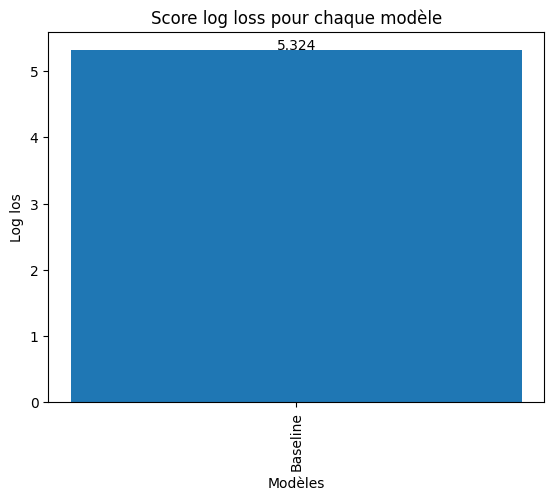

In [20]:
# Comparaison visuelle des log loss sur un digramme à bar
plot_log_loss_bar(results)

## 5.2- Regression logistique avec recherche aléatoire des meilleurs hyperparamètres

In [21]:
# Estimateur
lg_reg = LogisticRegression(penalty='elasticnet', solver='saga', n_jobs=-1, max_iter=10000, random_state=2023)

In [22]:
# Parametre grille
#param_grid = {'C': [1e-2, 1e-1, 0.3, 1e-0, 10, 76, 100], 'l1_ratio' : [0, 0.5, 1]}

# Recherche grille
#log_reg_grid_search = GridSearchCV(lg_reg, param_grid, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)

# fit grille
#log_reg_grid_search.fit(X_train, y_train)

#print(f'Le meilleur score grille est (auc moyen) : {log_reg_grid_search.best_score_}')
#print(f'Les meilleurs paramètres grille sont: {log_reg_grid_search.best_params_}')

# Score sur l'ensemble des données d'entrainement: Courbe ROC et AUC
#y_train_pred_proba_lg_reg = log_reg_grid_search.best_estimator_.predict_proba(X_train)[:,1]
#results['Regression logistique grille'] = y_train_pred_proba_lg_reg

#plot_roc_curve(y_train, results)

In [23]:
# Paramètres de la recherche aléatoire
param_rnd_search = dict(C = loguniform(1e-20, 1e2), l1_ratio = loguniform(10e-10,1))

# Recherche aléatoire: Nous précisons la valeur de cv pour avoir une validation croisée stratifiées à 5 plis
log_reg_rnd_search = RandomizedSearchCV(lg_reg, 
                                        param_rnd_search, 
                                        n_iter=100, 
                                        scoring='neg_log_loss', 
                                        cv=5, 
                                        verbose=1, 
                                        n_jobs=-1,
                                        random_state=2023)

In [24]:
# fit 
log_reg_rnd_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=10000, n_jobs=-1,
                                                penalty='elasticnet',
                                                random_state=2023,
                                                solver='saga'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fbd33d9be20>,
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fbd33dec070>},
                   random_state=2023, scoring='neg_log_loss', verbose=1)

In [25]:
results['Regression logistique'] = -log_reg_rnd_search.best_score_
print(f'Le meilleur score est (log loss moyen) : {-log_reg_rnd_search.best_score_}')
print(f'Les meilleurs paramètres sont: {log_reg_rnd_search.best_params_}')
best_lr = log_reg_rnd_search.best_estimator_

Le meilleur score est (log loss moyen) : 0.3289362627688452
Les meilleurs paramètres sont: {'C': 0.6193889824323069, 'l1_ratio': 0.2996004362847121}


In [26]:
# Score sur l'ensemble des données d'entrainement
#y_train_pred_proba_lg_reg_rnd = log_reg_rnd_search.best_estimator_.predict_proba(X_train)[:,1]
#results['Regression logistique'] = y_train_pred_proba_lg_reg_rnd

#plot_roc_curve(y_train, results)

#loss_log_reg = log_loss(y_train, y_train_pred_proba_lg_reg_rnd)
#results['Regression logistique'] = loss_log_reg
#print(f'Log loss Regression Logistique = {loss_log_reg}')

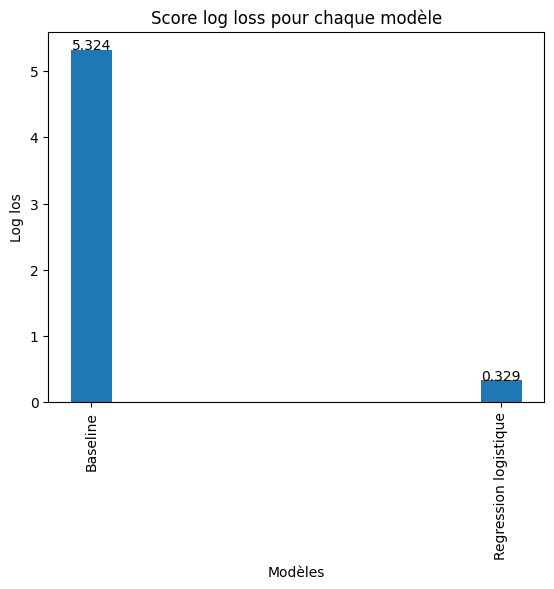

In [27]:
# Comparaison visuelle des log loss sur un digramme à bar
plot_log_loss_bar(results)

## 5.3- K plus proches voisin avec recherche aléatoire des meilleurs hyperparamètres

In [28]:
# Estimateur
knn_cf = KNeighborsClassifier(n_jobs=-1)

In [29]:
# Paramètres de la recherche aléatoire
param_rnd_search = dict(n_neighbors = randint(2, 50), weights = ['uniform', 'distance'])

# Remarque: avec np.arange(2, 51,1), le score est le même, mais le nombre de voisin pour le meilleur estimateur change.
# randint semble retourner plusieurs fois les valeurs pour satisfaire le nombre d'itération si cela s'impose, alors 
# que np.arange ne le fait pas. Par exemple, si nous mettons randint(2, 10), on s'attendrait à avoir 9*2 = 18 possibilités pour 
# nos paramètres, mais on réussit quand même à faire 100 iterations avec cela. Comment? nous allons creuser cela plutard.

# Recherche aléatoire
knn_rnd_search = RandomizedSearchCV(knn_cf, 
                                    param_rnd_search, 
                                    n_iter=100, 
                                    scoring='neg_log_loss', 
                                    cv=5, 
                                    verbose=1, 
                                    n_jobs=-1,
                                    random_state=2023)

In [30]:
# fit 
knn_rnd_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fbd91220be0>,
                                        'weights': ['uniform', 'distance']},
                   random_state=2023, scoring='neg_log_loss', verbose=1)

In [31]:
results['KNN'] = -knn_rnd_search.best_score_
print(f'Le meilleur score est (log loss moyen) : {-knn_rnd_search.best_score_}')
print(f'Les meilleurs paramètres sont: {knn_rnd_search.best_params_}')
best_knn = knn_rnd_search.best_estimator_

Le meilleur score est (log loss moyen) : 0.3436189168341346
Les meilleurs paramètres sont: {'n_neighbors': 42, 'weights': 'distance'}


In [32]:
# Score sur l'ensemble des données d'entrainement: Courbe ROC et AUC
#y_train_pred_proba_knn_rnd = knn_rnd_search.best_estimator_.predict_proba(X_train)[:,1]
#results['K voisins'] = y_train_pred_proba_knn_rnd

#plot_roc_curve(y_train, results)

#loss_log_knn = log_loss(y_train, y_train_pred_proba_knn_rnd)
#results['KNN'] = loss_log_knn
#print(f'Log loss knn = {loss_log_knn}')

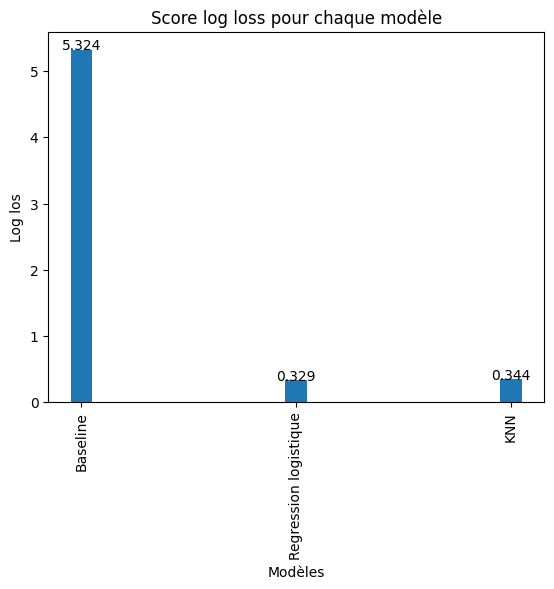

In [33]:
# Comparaison visuelle des log loss sur un digramme à bar
plot_log_loss_bar(results)

## 5.4- Arbre de décision

In [34]:
# Estimateur
dt_cf = DecisionTreeClassifier(random_state=2023)

In [35]:
# Paramètres de la recherche aléatoire
param_rnd_search = dict(ccp_alpha = loguniform(1e-3, 1e3),
                        criterion=['gini','entropy','log_loss'],
                        max_depth=randint(2, 35))

# Remarque: avec np.arange(2, 36,1), le resultat est le même.
# randint semble retourner plusieurs fois les valeurs pour satisfaire le nombre d'itération si cela s'impose, alors 
# que np.arange ne le fait pas.

# Recherche aléatoire
dt_rnd_search = RandomizedSearchCV(dt_cf, 
                                    param_rnd_search, 
                                    n_iter=100, 
                                    scoring='neg_log_loss', 
                                    cv=5, 
                                    verbose=1, 
                                    n_jobs=-1,
                                    random_state=2023)

In [36]:
# fit 
dt_rnd_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=2023),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'ccp_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fbd33def3a0>,
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fbd91257580>},
                   random_state=2023, scoring='neg_log_loss', verbose=1)

In [37]:
results['Decision Tree'] = -dt_rnd_search.best_score_
print(f'Le meilleur score est (log loss moyen) : {-dt_rnd_search.best_score_}')
print(f'Les meilleurs paramètres sont: {dt_rnd_search.best_params_}')
best_dt = dt_rnd_search.best_estimator_

Le meilleur score est (log loss moyen) : 0.37042836426045367
Les meilleurs paramètres sont: {'ccp_alpha': 0.004282248598847301, 'criterion': 'log_loss', 'max_depth': 24}


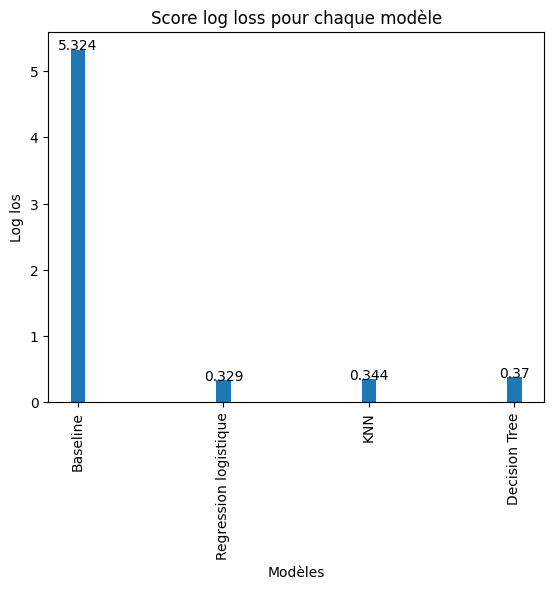

In [38]:
# Comparaison visuelle des log loss sur un digramme à bar
plot_log_loss_bar(results)

## 5.5- Forêt aléatoire

In [39]:
# Estimateur
rdf_cf = RandomForestClassifier(random_state=2023)

In [40]:
# Paramètres de la recherche aléatoire
param_rnd_search = dict(ccp_alpha = loguniform(1e-3, 1e3),
                        criterion=['gini','entropy','log_loss'],
                        max_depth=randint(2, 35),
                        n_estimators=randint(2,200))

# Remarque: avec np.arange(2, 36,1) et np.arange(2, 201,1) pour max_depth et n_estimators respectivement, le resultat est le 
# même. randint semble retourner plusieurs fois les valeurs pour satisfaire le nombre d'itération si cela s'impose, alors 
# que np.arange ne le fait pas.

# Recherche aléatoire
rd_forest_rnd_search = RandomizedSearchCV(rdf_cf, 
                                    param_rnd_search, 
                                    n_iter=20, 
                                    scoring='neg_log_loss', 
                                    cv=5, 
                                    verbose=1, 
                                    n_jobs=-1,
                                    random_state=2023)

In [41]:
# fit 
rd_forest_rnd_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2023),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'ccp_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fbd33e2d000>,
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fbd33e51ea0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fbd91223d00>},
                   random_state=2023, scoring='neg_log_loss', verbose=1)

In [42]:
results['Random Forest'] = -rd_forest_rnd_search.best_score_
print(f'Le meilleur score est (log loss moyen) : {-rd_forest_rnd_search.best_score_}')
print(f'Les meilleurs paramètres sont: {rd_forest_rnd_search.best_params_}')
best_rd_forest = rd_forest_rnd_search.best_estimator_

Le meilleur score est (log loss moyen) : 0.3316913859001574
Les meilleurs paramètres sont: {'ccp_alpha': 0.001237969183995374, 'criterion': 'entropy', 'max_depth': 13, 'n_estimators': 131}


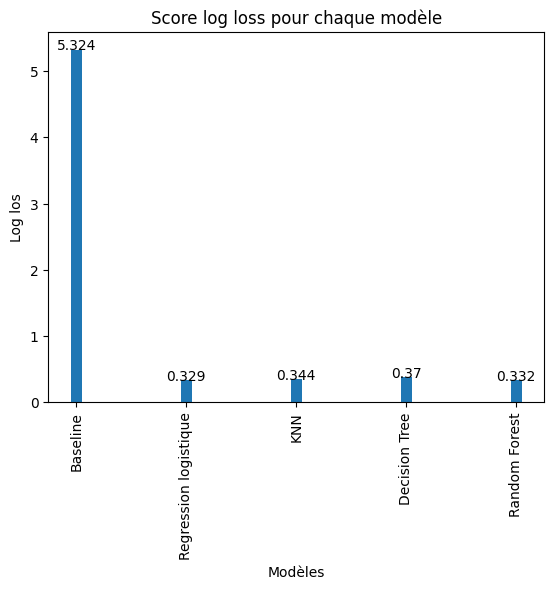

In [43]:
# Comparaison visuelle des log loss sur un digramme à bar
plot_log_loss_bar(results)

## 5.6- Bagging avec la meilleure regression logistique obtenue précédement pour essayer d'améliorer son score

In [44]:
# Estimateur
bg_cf = BaggingClassifier(estimator=log_reg_rnd_search.best_estimator_, random_state=2023)

In [45]:
# Paramètres de la recherche aléatoire
param_rnd_search = dict(
    n_estimators=randint(2,100))

# Remarque: avec np.arange(2, 101,1), le resultat est le même.
# randint semble retourner plusieurs fois les valeurs pour satisfaire le nombre d'itération si cela s'impose, alors 
# que np.arange ne le fait pas. Par exemple, si nous mettons randint(2, 10), on s'attendrait à avoir 9*2 = 18 possibilités pour 
# nos paramètres, mais on réussit quand même à faire 20 iterations avec cela. Comment? nous allons creuser cela plutard.

# Recherche aléatoire avec validation croisée
bg_cf_rnd_search = RandomizedSearchCV(bg_cf, 
                                      param_rnd_search, 
                                      n_iter=20, 
                                      cv=5, 
                                      scoring="neg_log_loss", 
                                      verbose=1, 
                                      n_jobs=-1, 
                                      random_state=2023)

In [46]:
# fit 
bg_cf_rnd_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=BaggingClassifier(estimator=LogisticRegression(C=0.6193889824323069,
                                                                            l1_ratio=0.2996004362847121,
                                                                            max_iter=10000,
                                                                            n_jobs=-1,
                                                                            penalty='elasticnet',
                                                                            random_state=2023,
                                                                            solver='saga'),
                                               random_state=2023),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fbd90981c60>},
                   random_state=2023, scoring='neg_log_loss', verbose=1)

In [47]:
results['Bagging Regression Logistique'] = -bg_cf_rnd_search.best_score_
print(f'Le meilleur score est (log loss moyen) : {-bg_cf_rnd_search.best_score_}')
print(f'Les meilleurs paramètres sont: {bg_cf_rnd_search.best_params_}')
best_bagging = bg_cf_rnd_search.best_estimator_

Le meilleur score est (log loss moyen) : 0.32879448061555083
Les meilleurs paramètres sont: {'n_estimators': 72}


NB: l'améloration de 0.000141 est insignifiante par rapport au coût d'entrainement du bagging que cela engendre.

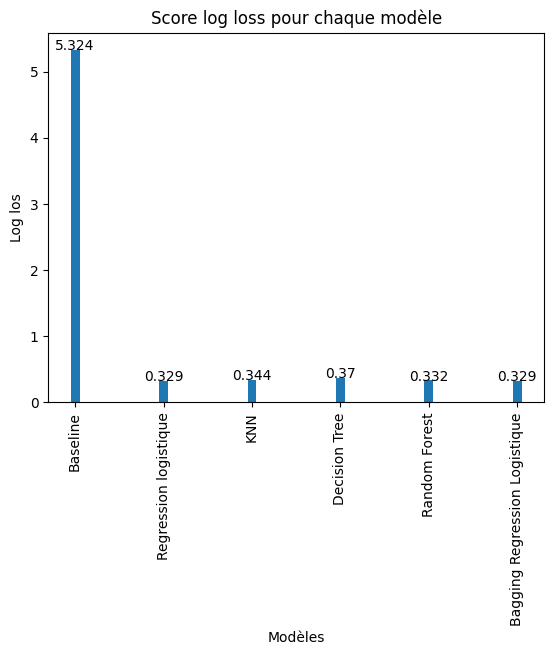

In [48]:
# Comparaison visuelle des log loss sur un digramme à bar
plot_log_loss_bar(results)

## 5.7- Gradient Boosting

In [49]:
# Estimateur
gb_cf = GradientBoostingClassifier(random_state=2023)

In [50]:
# Paramètres de la recherche aléatoire
param_rnd_search = dict(ccp_alpha = loguniform(1e-3, 1e3),
                        max_depth=randint(2, 6),
                        n_estimators=randint(2,200))

# Remarque: avec np.arange(2, 7,1) et np.arange(2, 201,1) pour max_depth et n_estimators respectivement, le score est le 
# même, mais les autres paramètres pour le best estimator sont différents. randint semble retourner plusieurs fois les valeurs 
# pour satisfaire le nombre d'itération si cela s'impose, alors que np.arange ne le fait pas.

# Recherche aléatoire
gb_rnd_search = RandomizedSearchCV(gb_cf, 
                                    param_rnd_search, 
                                    n_iter=20, 
                                    scoring='neg_log_loss', 
                                    cv=5, 
                                    verbose=1, 
                                    n_jobs=-1,
                                    random_state=2023)

In [51]:
# fit 
gb_rnd_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=GradientBoostingClassifier(random_state=2023),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'ccp_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fbd909ff4c0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fbd909ff310>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fbd909fea40>},
                   random_state=2023, scoring='neg_log_loss', verbose=1)

In [52]:
results['Gradient Booting'] = -gb_rnd_search.best_score_
print(f'Le meilleur score est (log loss moyen) : {-gb_rnd_search.best_score_}')
print(f'Les meilleurs paramètres sont: {gb_rnd_search.best_params_}')
best_gradient = gb_rnd_search.best_estimator_

Le meilleur score est (log loss moyen) : 0.36718684091509013
Les meilleurs paramètres sont: {'ccp_alpha': 0.001237969183995374, 'max_depth': 3, 'n_estimators': 36}


NB: Le resultat est moins bon que celui de regression logistique.

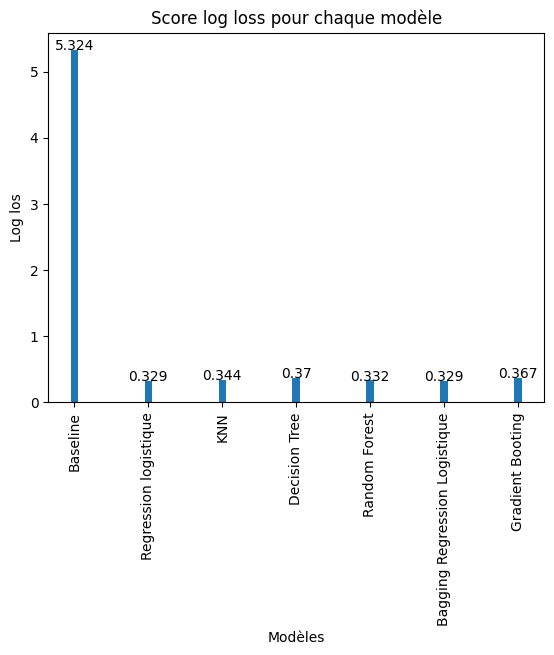

In [53]:
# Comparaison visuelle des log loss sur un digramme à bar
plot_log_loss_bar(results)

## 5.8 - Voting classifier

In [54]:
# Nous allons appliquer le voting classifier au 3 modèles de base précédents: Regression Logistique, KNN, Arbre de décision.

In [55]:
# Liste des estimateurs
estimators = [('lr', best_lr), 
              ('knn', best_knn),              
              ('dt', best_dt)]

In [56]:
voting = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

In [57]:
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.6193889824323069,
                                                 l1_ratio=0.2996004362847121,
                                                 max_iter=10000, n_jobs=-1,
                                                 penalty='elasticnet',
                                                 random_state=2023,
                                                 solver='saga')),
                             ('knn',
                              KNeighborsClassifier(n_jobs=-1, n_neighbors=42,
                                                   weights='distance')),
                             ('dt',
                              DecisionTreeClassifier(ccp_alpha=0.004282248598847301,
                                                     criterion='log_loss',
                                                     max_depth=24,
                                                     random_state=2023))],
                 n_jobs=-1, voting='soft')

In [58]:
# Score sur les plis de validation
score_log_loss_voting = -cross_val_score(voting, X_train, y_train, scoring='neg_log_loss', cv=strat_kfold, n_jobs=-1).mean()

In [59]:
print(f'Le score log loss pour le voting est de : {score_log_loss_voting}')

Le score log loss pour le voting est de : 0.3322930572138265


NB: Le resultat est moins bon que celui de regression logistique.

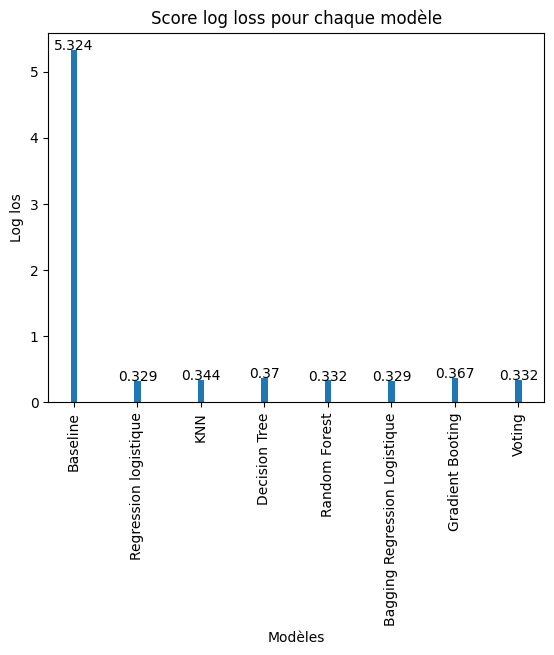

In [60]:
# Comparaison visuelle des log loss sur un digramme à bar
results['Voting'] = score_log_loss_voting
plot_log_loss_bar(results)

## 5.9- Stacking

In [61]:
# Nous allons ici tenter d'obtenir un meilleur modèle avec les techniques de stacking

### Stacking 1er variante

In [62]:
# Liste des estimateurs
estimators = [('lr', best_lr), 
              ('knn', best_knn),              
              ('dt', best_dt)]

In [63]:
stacking1 = StackingClassifier(estimators = estimators, cv=strat_kfold, final_estimator=LogisticRegression())

In [64]:
stacking1.fit(X_train, y_train)

StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=2023, shuffle=True),
                   estimators=[('lr',
                                LogisticRegression(C=0.6193889824323069,
                                                   l1_ratio=0.2996004362847121,
                                                   max_iter=10000, n_jobs=-1,
                                                   penalty='elasticnet',
                                                   random_state=2023,
                                                   solver='saga')),
                               ('knn',
                                KNeighborsClassifier(n_jobs=-1, n_neighbors=42,
                                                     weights='distance')),
                               ('dt',
                                DecisionTreeClassifier(ccp_alpha=0.004282248598847301,
                                                       criterion='log_loss',
                                                       max_depth=24,
                                                       random_state=2023))],
                   final_estimator=LogisticRegression())

In [65]:
# Score sur les plis de validation
score_log_loss_staking1 = -cross_val_score(stacking1, 
                                           X_train, 
                                           y_train, 
                                           scoring='neg_log_loss', 
                                           cv=strat_kfold, 
                                           n_jobs=-1).mean()

In [66]:
print(f'Le score log loss pour le stacking 1 est de : {score_log_loss_staking1}')

Le score log loss pour le stacking 1 est de : 0.3293418607330162


NB: l'améloration de 0.00041 est insignifiante par rapport au coût d'entrainement du stacking que cela engendre.

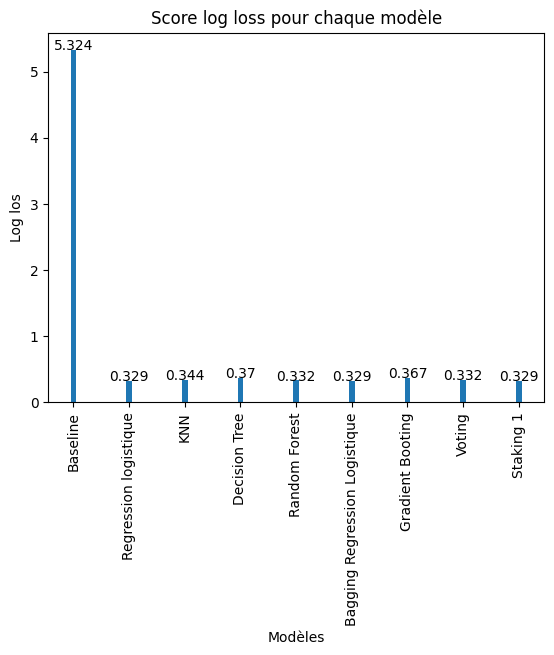

In [67]:
# Comparaison visuelle des log loss sur un digramme à bar
results['Staking 1'] = score_log_loss_staking1
plot_log_loss_bar(results)

### Stacking 2ieme variante

In [68]:
# Nous allons séparer notre jeux d'entrainement en 3 jeux de taille respective 50%, 25% et 25%
X_a, X_1, y_a, y_1 = train_test_split(X_train, y_train, stratify=y_train, random_state=2023, shuffle=True, train_size=0.50)

In [69]:
X_b, X_c, y_b, y_c = train_test_split(X_1, y_1, stratify=y_1, random_state=2023, shuffle=True, test_size=0.5)

In [70]:
# Estimateur à stacker
lr = best_lr
knn = best_knn
dt = best_dt

In [71]:
# Entrainement de la meilleure regression logistique sur X_1. 
lr.fit(X_1, y_1)

LogisticRegression(C=0.6193889824323069, l1_ratio=0.2996004362847121,
                   max_iter=10000, n_jobs=-1, penalty='elasticnet',
                   random_state=2023, solver='saga')

In [72]:
# Entrainement du meilleur KNN sur X_1. 
knn.fit(X_1, y_1)

KNeighborsClassifier(n_jobs=-1, n_neighbors=42, weights='distance')

In [73]:
# Entrainement du meilleur arbre de décision sur X_1. 
dt.fit(X_1, y_1)

DecisionTreeClassifier(ccp_alpha=0.004282248598847301, criterion='log_loss',
                       max_depth=24, random_state=2023)

In [74]:
# Prediction sur X_b et X_c et stockage des resultats dans X_b1 et X_c1: Jeux d'entrainement et de validation respective du 
# modèle final
X_b1 = np.hstack((lr.predict_proba(X_b)[:,1].reshape(-1,1),
                  knn.predict_proba(X_b)[:,1].reshape(-1,1), 
                  dt.predict_proba(X_b)[:,1].reshape(-1,1)))
X_c1 = np.hstack((lr.predict_proba(X_b)[:,1].reshape(-1,1),
                  knn.predict_proba(X_b)[:,1].reshape(-1,1), 
                  dt.predict_proba(X_b)[:,1].reshape(-1,1)))

In [75]:
# Estimateur final pour le stacking (Regression Logistique)
lr_final_staking = LogisticRegression(penalty='elasticnet', 
                                      random_state=2023, 
                                      C=0.6, 
                                      l1_ratio=0.3,
                                      max_iter=10000, 
                                      n_jobs=-1,
                                      solver='saga')

In [76]:
# fit de l'algorithme final sur X_b1 (prédictions des modèles de base sur X_b) 
lr_final_staking.fit(X_b1, y_b)

LogisticRegression(C=0.6, l1_ratio=0.3, max_iter=10000, n_jobs=-1,
                   penalty='elasticnet', random_state=2023, solver='saga')

In [77]:
# score de validation du model final de stacking sur le jeux de validation (X_c1)
score_val_log_loss_staking2 = -cross_val_score(lr_final_staking, 
                                               X_c1, 
                                               y_c, 
                                               scoring='neg_log_loss', 
                                               cv=strat_kfold, 
                                               n_jobs=-1).mean()
print(f'Le score val log loss pour le stacking 2 est de {score_val_log_loss_staking2}')

Le score val log loss pour le stacking 2 est de 0.42041288099998947


NB: Le resultat est moins bon que celui de regression logistique.

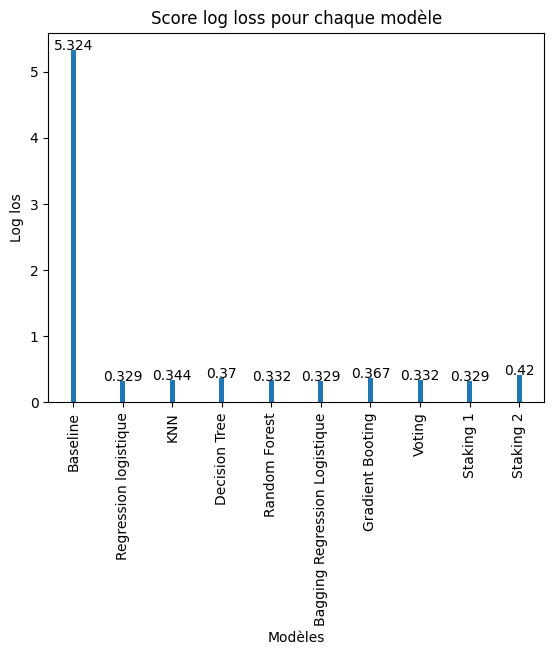

In [78]:
# Comparaison visuelle des log loss sur un digramme à bar
results['Staking 2'] = score_val_log_loss_staking2
plot_log_loss_bar(results)

# 6- Choix du modèle final et score final (sur le le jeux de test)

De tous ce qui précède, notre meilleur modèle de regression logistique, obtenu par recherche aléatoire des hyperparamètres, 
performe mieux que tout les autres modèles, avec un score (log_loss) sur les plis de validation de 0.3289362627688452 et les hyerparamètres suivants: {penalty: 'elasticnet', solver: 'saga', 'C': 0.6193889824323069, 'l1_ratio': 0.2996004362847121}

In [79]:
# Score du modèle final sur le jeux de test
y_predict_proba_test = best_lr.predict_proba(X_test)[:,1]
score_log_loss_final_test = log_loss(y_test, y_predict_proba_test)

In [80]:
print(f'Score final test : {score_log_loss_final_test}')

Score final test : 0.3352428373111055
